# Import Statements

In [34]:
%matplotlib inline
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import math
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import neighbors, linear_model, model_selection, tree, ensemble, naive_bayes, metrics, preprocessing, neural_network, decomposition
import math
import fuzzymatcher
from datetime import datetime
from meteostat import Daily
import time
sns.set()

# Dataframe Creation

In [2]:
# Query data files from NYC Open Data. Filter for last year (period of NYC e-record collection) and limit to 10k instance for milestone
vehicle_data = pd.read_csv('https://data.cityofnewyork.us/resource/bm4k-52h4.csv?$limit=10000000&$where=crash_date%20between%20%272016-01-01T01:00:00%27%20and%20%272021-10-01T23:00:00%27')
crashes_data = pd.read_csv('https://data.cityofnewyork.us/resource/h9gi-nx95.csv?$limit=10000000&$where=crash_date%20between%20%272016-01-01T01:00:00%27%20and%20%272021-10-01T23:00:00%27')
road_data = pd.read_csv('https://data.cityofnewyork.us/resource/m6hn-ddkx.csv?$query=SELECT%20distinct%20FULL_STREE,%20BIKE_LANE,%20ST_WIDTH,%20SNOW_PRI,%20TRAFDIR,%20RW_TYPE%20LIMIT%20150000')

In [3]:
# Combine Vehicle and Crash Dataframes based upon the collision_id, a standard identifier across all datasets. This provides vehicle information for each collision
data = vehicle_data.set_index('collision_id').join(crashes_data.set_index('collision_id'), lsuffix='_v', rsuffix='_c')

In [4]:
# Clean Street Name Data for second merger, aliging with Road Name in Road Data
data.rename(columns = {"on_street_name": "ST_NAME"}, inplace = True)
new = data["ST_NAME"].str.split(" ", n = 1, expand = True)
data["ST_NAME"] = new[0]
data["ST_NAME"] = data["ST_NAME"].str.strip()

In [5]:
# Average width of road over the length of the road (Different segments of the same road have varying widths)
st_width_mean= road_data.groupby('FULL_STREE', as_index=False)['ST_WIDTH'].mean()                        
road_data = pd.merge(road_data, st_width_mean, on='FULL_STREE', how='right')
road_data = road_data.drop('ST_WIDTH_x', axis=1).drop_duplicates('FULL_STREE')
road_data['BIKE_LANE'] = road_data['BIKE_LANE'].fillna(0.0)

In [6]:
# This cell may take 20-30 minutes to run

# Merge crash data with road data. Below displays all necessary data imported as a df
data = fuzzymatcher.fuzzy_left_join(data, road_data, 'ST_NAME', 'FULL_STREE') # Probablistic matching of dataframes. Manually inspected for matches based on the sorted df
pd.set_option("display.max_columns", 200)

In [7]:
#Prepare Weather Information DataFrame
# Set time period
start = datetime(2016, 1, 1)
end = datetime(2021, 10, 10)

# Get daily data, default 20 stations nearest point station location (KJRB0 is Wall Street, Manhattan)
weather_data = Daily('KJRB0', start, end)
weather_data = weather_data.fetch()
weather_data.drop(['tmin','tmax', 'wdir', 'wpgt', 'pres', 'tsun'], axis=1, inplace=True)
weather_data = weather_data.reset_index()

weather_data
weather_data['date_clean']=pd.to_datetime(weather_data['time'])
weather_data.drop(['time'], axis=1, inplace=True)

In [8]:
# Final Merged DataFrame combining vehicle information, collision information, road information, and weather information
data['date_clean'] = pd.to_datetime(data['crash_date_v'].str[0:10])
data = data.merge(weather_data, on='date_clean', how='left')
data.head()

,best_match_score,__id_left,__id_right,unique_id,crash_date_v,crash_time_v,vehicle_id,state_registration,vehicle_type,vehicle_make,vehicle_model,vehicle_year,travel_direction,vehicle_occupants,driver_sex,driver_license_status,driver_license_jurisdiction,pre_crash,point_of_impact,vehicle_damage,vehicle_damage_1,vehicle_damage_2,vehicle_damage_3,public_property_damage,public_property_damage_type,contributing_factor_1,contributing_factor_2,crash_date_c,crash_time_c,borough,zip_code,latitude,longitude,location,ST_NAME,off_street_name,cross_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,contributing_factor_vehicle_1,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,vehicle_type_code1,vehicle_type_code2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,FULL_STREE,BIKE_LANE,SNOW_PRI,TRAFDIR,RW_TYPE,ST_WIDTH_y,date_clean,tavg,prcp,snow,wspd
0,0.224179,0_left,9637_right,14999023,2016-01-02T00:00:00.000,3:04,1,NY,TAXI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Going Straight Ahead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unspecified,NaN,2016-01-02T00:00:00.000,3:04,MANHATTAN,10013.0,40.723747,-74.006115,"(40.7237466, -74.0061151)",VARICK,WATTS STREET,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,TAXI,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,VARICK ST,1.0,C,TF,1.0,45.200000,2016-01-02,NaN,NaN,NaN,NaN
1,0.224179,1_left,9637_right,14999024,2016-01-02T00:00:00.000,3:04,2,NY,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Going Straight Ahead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unspecified,NaN,2016-01-02T00:00:00.000,3:04,MANHATTAN,10013.0,40.723747,-74.006115,"(40.7237466, -74.0061151)",VARICK,WATTS STREET,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,TAXI,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,VARICK ST,1.0,C,TF,1.0,45.200000,2016-01-02,NaN,NaN,NaN,NaN
2,0.206932,2_left,2405_right,14999025,2016-01-02T00:00:00.000,4:40,1,NY,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Going Straight Ahead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unspecified,NaN,2016-01-02T00:00:00.000,4:40,MANHATTAN,10007.0,40.713056,-74.007225,"(40.7130557, -74.0072251)",BROADWAY,MURRAY STREET,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,SPORT UTILITY / STATION WAGON,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,BROADWAY,0.0,C,TF,1.0,38.494382,2016-01-02,NaN,NaN,NaN,NaN
3,0.206932,3_left,2405_right,14999026,2016-01-02T00:00:00.000,4:40,2,NY,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Making Right Turn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unspecified,NaN,2016-01-02T00:00:00.000,4:40,MANHATTAN,10007.0,40.713056,-74.007225,"(40.7130557, -74.0072251)",BROADWAY,MURRAY STREET,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,SPORT UTILITY / STATION WAGON,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,BROADWAY,0.0,C,TF,1.0,38.494382,2016-01-02,NaN,NaN,NaN,NaN
4,0.164719,4_left,5174_right,14999028,2016-01-02T00:00:00.000,12:00,2,NY,TAXI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Going Straight Ahead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unspecified,NaN,2016-01-02T00:00:00.000,12:00,MANHATTAN,10013.0,40.722717,-74.004448,"(40.7227174, -74.0044483)",GRAND,THOMPSON STREET,NaN,0.0,0.0,0,0,0,0,0,0,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN,PASSENGER VEHICLE,TAXI,NaN,NaN,NaN,GRAND ST,0.0,S,TW,1.0,43.428571,2016-01-02,NaN,NaN,NaN,NaN


In [9]:
# Comment out this cell or change the pathway if you would like to save a hard copy at this point
# data.to_csv('/Users/dannymathieson/Desktop/MachineLearning/Project_Data.csv')


# Data Preprocessing

In [10]:
# Drop duplicate and irrelevant columns from the above merge. Reset identifiyng index for a unique index number
data.drop(['best_match_score', '__id_left', '__id_right', 'unique_id', 'vehicle_id', 'vehicle_make', 'vehicle_model', 'vehicle_damage_1', 'vehicle_damage_2', 
           'vehicle_damage_3', 'public_property_damage_type', 'crash_date_c','crash_time_c', 'location', 'off_street_name',
           'cross_street_name', 'contributing_factor_1', 'contributing_factor_2', 'contributing_factor_vehicle_2',	'contributing_factor_vehicle_3',
           'contributing_factor_vehicle_4', 'contributing_factor_vehicle_5', 'vehicle_type_code1', 'vehicle_type_code2', 'vehicle_type_code_3',
           'vehicle_type_code_4', 'vehicle_type_code_5', 'date_clean'], axis=1, inplace=True)
data.rename(columns={'crash_date_v':'crash_date','crash_time_v':'crash_time'}, inplace=True)
data.reset_index(inplace = True)
data.drop(['index'], axis=1, inplace=True)

In [11]:
# Processing of date and time objects
data['crash_date'] = pd.to_datetime(data['crash_date'])
data['crash_time'] = pd.to_datetime(data['crash_time'])
# day
data['Day'] = data['crash_date'].dt.day
# month
data['Month'] = data['crash_date'].dt.month
# year
data['Year'] = data['crash_date'].dt.year
# hour
data['Hour'] = data['crash_time'].dt.hour
# minute
data['Minute'] = data['crash_time'].dt.minute
# day of week
data['week_day'] = data['crash_date'].dt.weekday
# Holiday processing
cal = calendar()
holidays = cal.holidays(start=data['crash_date'].min(), end=data['crash_date'].max())              
data['holiday'] = data['crash_date'].isin(holidays)
data['holiday'].replace({False:0, True:1}, inplace=True)
data.drop(['crash_date', 'crash_time'], axis=1, inplace=True)

In [12]:
# Creation of Pedestrian Involved and Cyclist Involved Features
data['Pedestrian_Involved'] = ((data['number_of_pedestrians_injured'] > 0) | (data['number_of_pedestrians_killed'] > 0))
data['Pedestrian_Involved']= data['Pedestrian_Involved'].replace (False, 0)
data['Pedestrian_Involved']= data['Pedestrian_Involved'].replace (True, 1);
data['Cyclist_Involved'] = ((data['number_of_cyclist_injured'] > 0) | (data['number_of_cyclist_killed'] > 0))
data['Cyclist_Involved']= data['Cyclist_Involved'].replace (False, 0)
data['Cyclist_Involved']= data['Cyclist_Involved'].replace (True, 1);

In [13]:
# Creation of a Binary Target Variable indicating an accident with an injury or fatality
data['Injury'] = ((data['number_of_persons_injured'] > 0) | (data['number_of_persons_killed'] > 0))
data['Injury']= data['Injury'].replace (False, "No Injury")
data['Injury']= data['Injury'].replace (True, "Injury");
data['Injury'] = pd.Categorical(data['Injury'] , ['No Injury','Injury'])
data = data.drop(['number_of_persons_injured', 'number_of_persons_killed', 'number_of_pedestrians_killed', 'number_of_pedestrians_injured', 
                 'number_of_cyclist_injured', 'number_of_cyclist_killed', 'number_of_motorist_injured', 'number_of_motorist_killed'], axis=1)
data.head()

,state_registration,vehicle_type,vehicle_year,travel_direction,vehicle_occupants,driver_sex,driver_license_status,driver_license_jurisdiction,pre_crash,point_of_impact,vehicle_damage,public_property_damage,borough,zip_code,latitude,longitude,ST_NAME,contributing_factor_vehicle_1,FULL_STREE,BIKE_LANE,SNOW_PRI,TRAFDIR,RW_TYPE,ST_WIDTH_y,tavg,prcp,snow,wspd,Day,Month,Year,Hour,Minute,week_day,holiday,Pedestrian_Involved,Cyclist_Involved,Injury
0,NY,TAXI,NaN,NaN,NaN,NaN,NaN,NaN,Going Straight Ahead,NaN,NaN,NaN,MANHATTAN,10013.0,40.723747,-74.006115,VARICK,Unspecified,VARICK ST,1.0,C,TF,1.0,45.200000,NaN,NaN,NaN,NaN,2,1,2016,3,4,5,0,0,0,No Injury
1,NY,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN,NaN,NaN,Going Straight Ahead,NaN,NaN,NaN,MANHATTAN,10013.0,40.723747,-74.006115,VARICK,Unspecified,VARICK ST,1.0,C,TF,1.0,45.200000,NaN,NaN,NaN,NaN,2,1,2016,3,4,5,0,0,0,No Injury
2,NY,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN,NaN,NaN,Going Straight Ahead,NaN,NaN,NaN,MANHATTAN,10007.0,40.713056,-74.007225,BROADWAY,Unspecified,BROADWAY,0.0,C,TF,1.0,38.494382,NaN,NaN,NaN,NaN,2,1,2016,4,40,5,0,0,0,No Injury
3,NY,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN,NaN,NaN,Making Right Turn,NaN,NaN,NaN,MANHATTAN,10007.0,40.713056,-74.007225,BROADWAY,Unspecified,BROADWAY,0.0,C,TF,1.0,38.494382,NaN,NaN,NaN,NaN,2,1,2016,4,40,5,0,0,0,No Injury
4,NY,TAXI,NaN,NaN,NaN,NaN,NaN,NaN,Going Straight Ahead,NaN,NaN,NaN,MANHATTAN,10013.0,40.722717,-74.004448,GRAND,Failure to Yield Right-of-Way,GRAND ST,0.0,S,TW,1.0,43.428571,NaN,NaN,NaN,NaN,2,1,2016,12,0,5,0,0,0,No Injury


In [14]:
# View the counts of null values and the datatype of each feature
pd.set_option("display.max_rows", 100)
data.replace("Unspecified", np.nan, inplace=True)
null_values = pd.DataFrame((data.isnull().sum()), columns = ['null_count'])
null_values['% Missing'] = null_values['null_count']/ data.shape[0]
null_values['dtype'] = data.dtypes
null_values['Unique Values'] = data.nunique()
null_values

,null_count,% Missing,dtype,Unique Values
state_registration,207711,0.093747,object,72
vehicle_type,170604,0.076999,object,2092
vehicle_year,340767,0.153799,float64,297
travel_direction,184030,0.083059,object,15
vehicle_occupants,265252,0.119717,float64,120
driver_sex,588044,0.265403,object,3
driver_license_status,654090,0.295211,object,3
driver_license_jurisdiction,646144,0.291625,object,70
pre_crash,131762,0.059468,object,19
point_of_impact,210928,0.095198,object,19


In [15]:
# Identify Modes for imputing null values
data.mode().head()

,state_registration,vehicle_type,vehicle_year,travel_direction,vehicle_occupants,driver_sex,driver_license_status,driver_license_jurisdiction,pre_crash,point_of_impact,vehicle_damage,public_property_damage,borough,zip_code,latitude,longitude,ST_NAME,contributing_factor_vehicle_1,FULL_STREE,BIKE_LANE,SNOW_PRI,TRAFDIR,RW_TYPE,ST_WIDTH_y,tavg,prcp,snow,wspd,Day,Month,Year,Hour,Minute,week_day,holiday,Pedestrian_Involved,Cyclist_Involved,Injury
0,NY,Sedan,2016.0,West,1.0,M,Licensed,NY,Going Straight Ahead,Center Front End,Center Front End,N,BROOKLYN,11207.0,0.0,0.0,EAST,Driver Inattention/Distraction,EAST AVE,0.0,C,TW,1.0,30.0,24.8,0.0,NaN,8.5,15,6,2018,16,0,4,0,0,0,No Injury


In [16]:
# Impute with median value for following categories
data['vehicle_year'] = data['vehicle_year'].fillna(data['vehicle_year'].median())
data['vehicle_occupants'] = data['vehicle_occupants'].fillna(data['vehicle_occupants'].median())
data['ST_WIDTH_y'] = data['ST_WIDTH_y'].fillna(data['ST_WIDTH_y'].median())

In [17]:
# Drop features with large proportion of missing values
data = data.drop (['zip_code', 'borough', 'driver_sex', 'driver_license_jurisdiction','driver_license_status', 'FULL_STREE', 'ST_NAME', 'snow'], axis=1)

In [18]:
# Impute other missing values with mode. Feature mode often indicates N/A or uknown. See below.
for column in data:
    if data[column].isnull().any():
            data[column]=data[column].fillna(data[column].mode()[0])

In [19]:
#Cast floats to ints to save memory
data.vehicle_year = data.vehicle_year.astype(int)
data.vehicle_occupants = data.vehicle_occupants.astype(int)
data.BIKE_LANE = data.BIKE_LANE.astype(int)

In [20]:
#Filter data to remove spurious entries and those with data entry errors (E.g. typos)
data= data.groupby('vehicle_type').filter(lambda x : len(x)>10000)
data= data.groupby('travel_direction').filter(lambda x : len(x)>1500)

# Data Exploration

In [22]:
# Comment out this cell or change the pathway if you would like to save a hard copy at this point

#data.to_csv('/Users/dannymathieson/Desktop/MachineLearning/Cleaned_Data.csv')
data.head()

,state_registration,vehicle_type,vehicle_year,travel_direction,vehicle_occupants,pre_crash,point_of_impact,vehicle_damage,public_property_damage,latitude,longitude,contributing_factor_vehicle_1,BIKE_LANE,SNOW_PRI,TRAFDIR,RW_TYPE,ST_WIDTH_y,tavg,prcp,wspd,Day,Month,Year,Hour,Minute,week_day,holiday,Pedestrian_Involved,Cyclist_Involved,Injury
1,NY,SPORT UTILITY / STATION WAGON,2013,West,1,Going Straight Ahead,Center Front End,Center Front End,N,40.723747,-74.006115,Driver Inattention/Distraction,1,C,TF,1.0,45.200000,24.8,0.0,8.5,2,1,2016,3,4,5,0,0,0,No Injury
2,NY,SPORT UTILITY / STATION WAGON,2013,West,1,Going Straight Ahead,Center Front End,Center Front End,N,40.713056,-74.007225,Driver Inattention/Distraction,0,C,TF,1.0,38.494382,24.8,0.0,8.5,2,1,2016,4,40,5,0,0,0,No Injury
3,NY,SPORT UTILITY / STATION WAGON,2013,West,1,Making Right Turn,Center Front End,Center Front End,N,40.713056,-74.007225,Driver Inattention/Distraction,0,C,TF,1.0,38.494382,24.8,0.0,8.5,2,1,2016,4,40,5,0,0,0,No Injury
5,NY,PASSENGER VEHICLE,2013,West,1,Going Straight Ahead,Center Front End,Center Front End,N,40.722717,-74.004448,Failure to Yield Right-of-Way,0,S,TW,1.0,43.428571,24.8,0.0,8.5,2,1,2016,12,0,5,0,0,0,No Injury
6,NY,SPORT UTILITY / STATION WAGON,2013,West,1,Passing,Center Front End,Center Front End,N,40.711593,-73.994265,Driver Inattention/Distraction,0,V,TW,1.0,28.818182,24.8,0.0,8.5,2,1,2016,5,0,5,0,0,0,No Injury


,Hour,Injury,No Injury
Year,,,
2016,415972,77326,338646
2017,451317,83306,368011
2018,452906,85581,367325
2019,414484,84950,329534
2020,221918,62605,159313
2021,161299,52609,108690


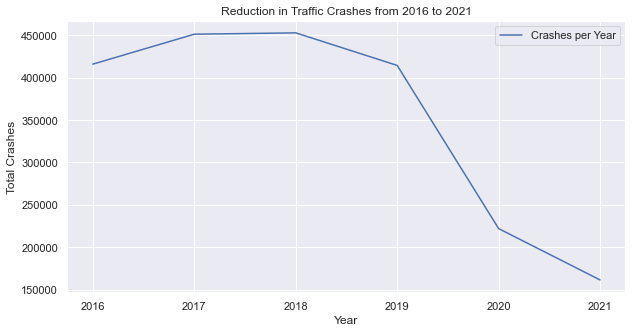

In [23]:
# Total Crashes by Year
year_data = pd.DataFrame(data.groupby('Year').count()['Hour'])
year_data['Injury' ] = pd.DataFrame(data.loc[(data.Injury == "Injury")].groupby('Year').count()['Hour'])
year_data['No Injury'] = pd.DataFrame(data.loc[(data.Injury == "No Injury")].groupby('Year').count()['Hour'])
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.lineplot(data=year_data, x="Year", y="Hour", label='Crashes per Year');
ax.set_ylabel('Total Crashes')
ax.set_title('Reduction in Traffic Crashes from 2016 to 2021');
year_data

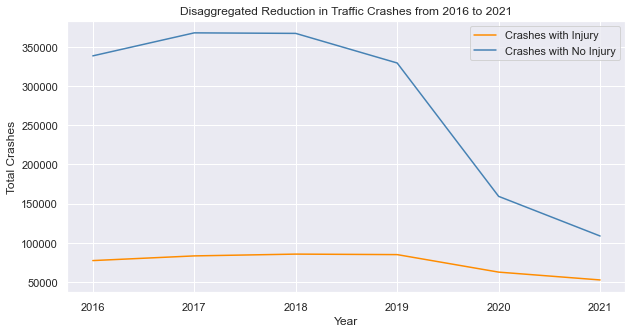

In [24]:
# Total Crashes by Year, disaggregated by classes
fig, ax = plt.subplots(figsize=(10,5))
ax= sns.lineplot(x='Year', y='Injury', data=year_data, color='darkorange', label= 'Crashes with Injury')
ax1 = sns.lineplot(x='Year', y='No Injury', data=year_data, color='steelblue', label= 'Crashes with No Injury')
ax.set(xlabel='Year', ylabel='Total Crashes');
ax.set_title('Disaggregated Reduction in Traffic Crashes from 2016 to 2021');

In [25]:
# Ensure proper ordering of figures with respect to class
data['Injury'] = pd.Categorical(data['Injury'] , ['No Injury','Injury'])
hue_order = ["No Injury", "Injury"]

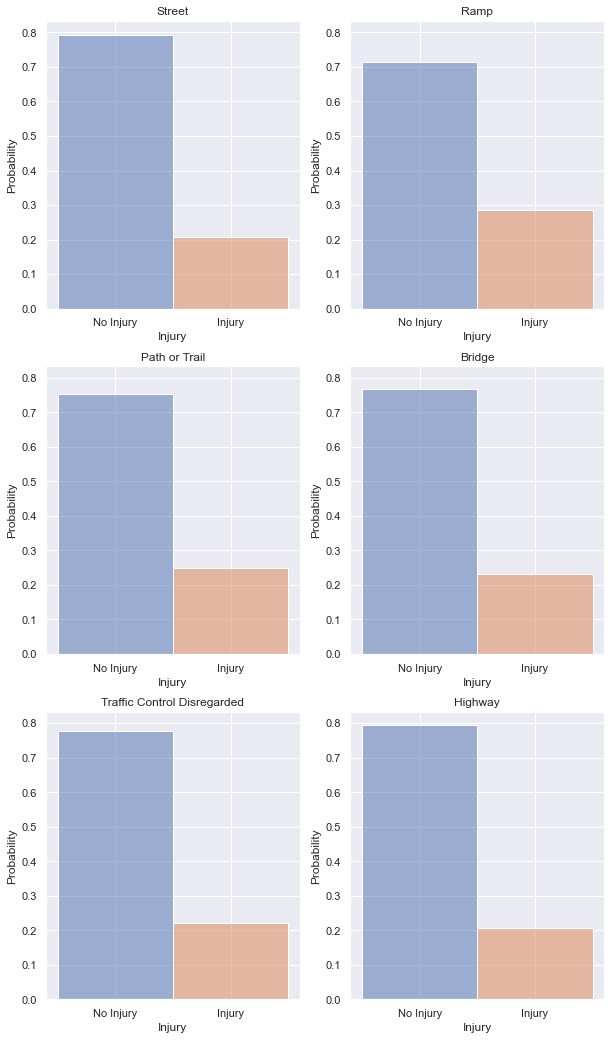

In [26]:
# Class probability to roadway type
fig, axes = plt.subplots(3, 2, figsize=(10, 18), sharey=True)
axes[0][0].set_title('Street')
sns.histplot(ax=axes[0][0], data=data[data['RW_TYPE'] == 1], x="Injury", hue="Injury", stat='probability', legend=None, hue_order=hue_order);
axes[0][1].set_title('Ramp')
axes[0][1].yaxis.set_tick_params(labelleft=True)
sns.histplot(ax=axes[0][1], data=data[data['RW_TYPE'] == 9], x="Injury", hue="Injury", stat='probability',legend=None, hue_order=hue_order);
axes[1][0].set_title('Path or Trail')
axes[1][0].yaxis.set_tick_params(labelleft=True)
sns.histplot(ax=axes[1][0], data=data[data['RW_TYPE'] == 6], x="Injury", hue="Injury", stat='probability',legend=None, hue_order=hue_order);
axes[1][1].set_title('Bridge')
axes[1][1].yaxis.set_tick_params(labelleft=True)
sns.histplot(ax=axes[1][1], data=data[data['RW_TYPE'] == 3], x="Injury", hue="Injury", stat='probability',legend=None, hue_order=hue_order);
axes[2][0].set_title('Traffic Control Disregarded')
axes[2][0].yaxis.set_tick_params(labelleft=True)
sns.histplot(ax=axes[2][0], data=data[data['RW_TYPE'] == 14], x="Injury", hue="Injury", stat='probability',legend=None, hue_order=hue_order);
axes[2][1].set_title('Highway')
axes[2][1].yaxis.set_tick_params(labelleft=True)
sns.histplot(ax=axes[2][1], data=data[data['RW_TYPE'] == 2], x="Injury", hue="Injury", stat='probability',legend=None, hue_order=hue_order);

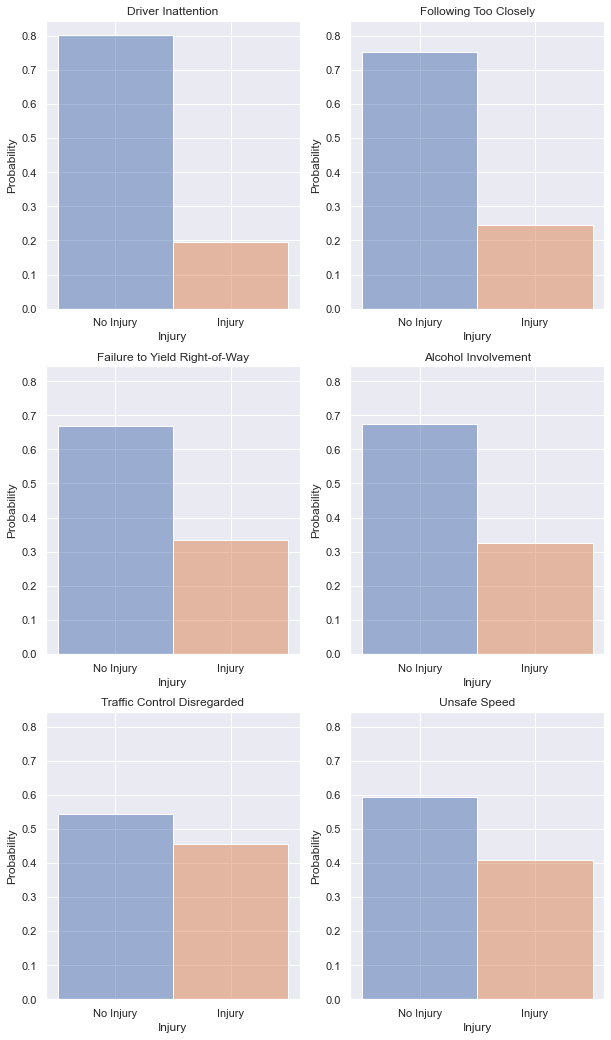

In [27]:
# Class probability to contributing factor
fig, axes = plt.subplots(3, 2, figsize=(10, 18), sharey=True)
axes[0][0].set_title('Driver Inattention')
sns.histplot(ax=axes[0][0], data=data[data['contributing_factor_vehicle_1'].str.contains("Driver Inattention/Distraction")], x="Injury", hue="Injury", stat='probability', legend=None, hue_order=hue_order);
axes[0][1].set_title('Following Too Closely')
axes[0][1].yaxis.set_tick_params(labelleft=True)
sns.histplot(ax=axes[0][1], data=data[data['contributing_factor_vehicle_1'].str.contains("Following Too Closely")], x="Injury", hue="Injury", stat='probability',legend=None, hue_order=hue_order);
axes[1][0].set_title('Failure to Yield Right-of-Way')
axes[1][0].yaxis.set_tick_params(labelleft=True)
sns.histplot(ax=axes[1][0], data=data[data['contributing_factor_vehicle_1'].str.contains("Failure to Yield Right-of-Way")], x="Injury", hue="Injury", stat='probability',legend=None, hue_order=hue_order);
axes[1][1].set_title('Alcohol Involvement')
axes[1][1].yaxis.set_tick_params(labelleft=True)
sns.histplot(ax=axes[1][1], data=data[data['contributing_factor_vehicle_1'].str.contains("Alcohol")], x="Injury", hue="Injury", stat='probability',legend=None, hue_order=hue_order);
axes[2][0].set_title('Traffic Control Disregarded')
axes[2][0].yaxis.set_tick_params(labelleft=True)
sns.histplot(ax=axes[2][0], data=data[data['contributing_factor_vehicle_1'].str.contains("Traffic Control Disregarded")], x="Injury", hue="Injury", stat='probability',legend=None, hue_order=hue_order);
axes[2][1].set_title('Unsafe Speed')
axes[2][1].yaxis.set_tick_params(labelleft=True)
sns.histplot(ax=axes[2][1], data=data[data['contributing_factor_vehicle_1'].str.contains("Unsafe Speed")], x="Injury", hue="Injury", stat='probability',legend=None, hue_order=hue_order);

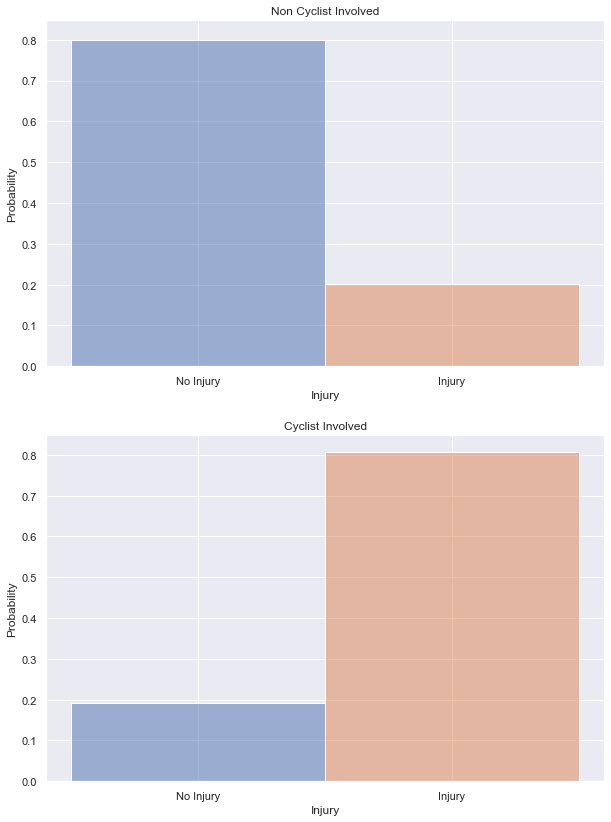

In [28]:
# Class probability to cyclist involvement
fig, axes = plt.subplots(2, 1, figsize=(10, 14), sharey=True)
axes[0].set_title('Non Cyclist Involved')
axes[0].yaxis.set_tick_params(labelleft=True)
sns.histplot(ax=axes[0], data=data[data['vehicle_type'] != 'Bike'], x="Injury", hue="Injury", stat='probability', legend=None, hue_order=hue_order);
axes[1].set_title('Cyclist Involved')
axes[1].yaxis.set_tick_params(labelleft=True)
sns.histplot(ax=axes[1], data=data[data['vehicle_type'] == 'Bike'], x="Injury", hue="Injury", stat='probability', legend=None, hue_order=hue_order);

# Final Data Processing for Machine Learning

In [29]:
# View Counts of Classes
data['Injury'].value_counts()

No Injury    1671519
Injury        446377
Name: Injury, dtype: int64

In [30]:
# Drop target and columns that directly identify target
le = preprocessing.LabelEncoder()
y = pd.DataFrame(le.fit_transform(data.Injury))
X = data.drop(['Injury'], axis=1)

# Drop features indicative of target
X = X.drop(['Pedestrian_Involved', 'Cyclist_Involved'], axis=1)
X.head()

,state_registration,vehicle_type,vehicle_year,travel_direction,vehicle_occupants,pre_crash,point_of_impact,vehicle_damage,public_property_damage,latitude,longitude,contributing_factor_vehicle_1,BIKE_LANE,SNOW_PRI,TRAFDIR,RW_TYPE,ST_WIDTH_y,tavg,prcp,wspd,Day,Month,Year,Hour,Minute,week_day,holiday
1,NY,SPORT UTILITY / STATION WAGON,2013,West,1,Going Straight Ahead,Center Front End,Center Front End,N,40.723747,-74.006115,Driver Inattention/Distraction,1,C,TF,1.0,45.200000,24.8,0.0,8.5,2,1,2016,3,4,5,0
2,NY,SPORT UTILITY / STATION WAGON,2013,West,1,Going Straight Ahead,Center Front End,Center Front End,N,40.713056,-74.007225,Driver Inattention/Distraction,0,C,TF,1.0,38.494382,24.8,0.0,8.5,2,1,2016,4,40,5,0
3,NY,SPORT UTILITY / STATION WAGON,2013,West,1,Making Right Turn,Center Front End,Center Front End,N,40.713056,-74.007225,Driver Inattention/Distraction,0,C,TF,1.0,38.494382,24.8,0.0,8.5,2,1,2016,4,40,5,0
5,NY,PASSENGER VEHICLE,2013,West,1,Going Straight Ahead,Center Front End,Center Front End,N,40.722717,-74.004448,Failure to Yield Right-of-Way,0,S,TW,1.0,43.428571,24.8,0.0,8.5,2,1,2016,12,0,5,0
6,NY,SPORT UTILITY / STATION WAGON,2013,West,1,Passing,Center Front End,Center Front End,N,40.711593,-73.994265,Driver Inattention/Distraction,0,V,TW,1.0,28.818182,24.8,0.0,8.5,2,1,2016,5,0,5,0


In [31]:
# One Hot Encode dependent variables. FINAL SHAPE OF DATA
X = pd.get_dummies(X)
X.shape

(2117896, 237)

In [32]:
#Sample dataset for testing model performance on a smaller subset of data
X_samples = X.iloc[::100, :]
y_samples = y.iloc[::100, :]

# Supervised Learning for Classification

In [33]:
# Functions for running and validating supervised classification models
def model_eval(df, target, model):

    kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True)

    # Arrays to store metrics
    recall = []
    precision = []
    f1 = []
    timer = []


    for train_index, test_index in kf.split(df, target):
        X_train, X_test = df.iloc[train_index], df.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        start = time.time()
        model.fit(X_train, y_train)
        time_spent = time.time() - start

        y_pred = model.predict(X_test)

        recall += [metrics.recall_score(y_pred, y_test, average="weighted", labels=[1])]
        precision += [metrics.precision_score(y_pred, y_test, average="weighted", labels=[1])]
        f1 += [metrics.f1_score(y_pred, y_test, average="weighted", labels=[1])]
        timer+= [time_spent]

    
    print("recall    = {:.4f} ±{:.4f}".format(np.mean(recall), np.std(recall)))
    print("precision = {:.4f} ±{:.4f}".format(np.mean(precision), np.std(precision)))
    print("f1        = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))
    print('The time to fit this model was {:.4f} seconds'.format(np.mean(timer)))
    return np.mean(f1)
    
def scaled_model_eval(df, target, model):

    kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True)

    # Arrays to store metrics
    recall = []
    precision = []
    f1 = []
    timer = []


    for train_index, test_index in kf.split(df, target):
        X_train, X_test = df.iloc[train_index], df.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        X_scaler = preprocessing.MinMaxScaler()
    
        X_train = X_scaler.fit_transform(X_train)
        start = time.time()

        model.fit(X_train, y_train)
        time_spent = time.time() - start

        X_test = X_scaler.transform(X_test)
        y_pred = model.predict(X_test)

        
        recall += [metrics.recall_score(y_pred, y_test, average="weighted", labels=[1])]
        precision += [metrics.precision_score(y_pred, y_test, average="weighted", labels=[1])]
        f1 += [metrics.f1_score(y_pred, y_test, average="weighted", labels=[1])]
        timer+= [time_spent]


    
    print("recall    = {:.4f} ±{:.4f}".format(np.mean(recall), np.std(recall)))
    print("precision = {:.4f} ±{:.4f}".format(np.mean(precision), np.std(precision)))
    print("f1        = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))
    print('The time to fit this model was {:.4f} seconds'.format(np.mean(timer)))
    return np.mean(f1)


# Experimentation on Subset of Data

## Decision Tree Classifier

In [126]:
dt_model = tree.DecisionTreeClassifier(random_state=42, max_depth=1, criterion="entropy")
model_eval(X_samples, y_samples, dt_model)

recall    = 0.8000 ±0.0014
precision = 0.9970 ±0.0004
f1        = 0.8877 ±0.0008
The time to fit this model was 0.0506 seconds


0.8876838369017627

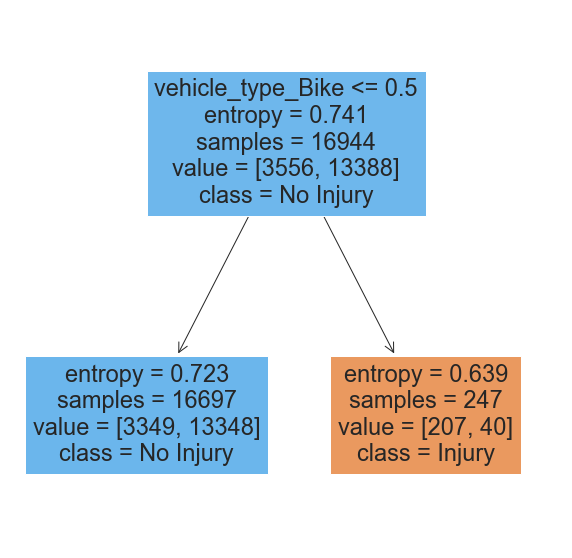

In [127]:
fig = plt.figure(figsize=(10,10))
_ = tree.plot_tree(dt_model, feature_names=X_samples.columns,  
                   class_names=['Injury', 'No Injury'],
                   filled=True)

In [128]:
dt_model = tree.DecisionTreeClassifier(random_state=42, criterion="entropy")
model_eval(X_samples, y_samples, dt_model)

recall    = 0.8234 ±0.0050
precision = 0.8107 ±0.0048
f1        = 0.8170 ±0.0042
The time to fit this model was 0.3419 seconds


0.8169832586048003



Results for Tree of Depth 5
recall    = 0.8052 ±0.0013
precision = 0.9839 ±0.0049
f1        = 0.8856 ±0.0014
The time to fit this model was 0.1184 seconds


Results for Tree of Depth 10
recall    = 0.8169 ±0.0041
precision = 0.9557 ±0.0102
f1        = 0.8808 ±0.0035
The time to fit this model was 0.1827 seconds


Results for Tree of Depth 25
recall    = 0.8266 ±0.0060
precision = 0.8444 ±0.0043
f1        = 0.8354 ±0.0024
The time to fit this model was 0.3371 seconds


Results for Tree of Depth 50
recall    = 0.8225 ±0.0034
precision = 0.8168 ±0.0066
f1        = 0.8196 ±0.0040
The time to fit this model was 0.3543 seconds


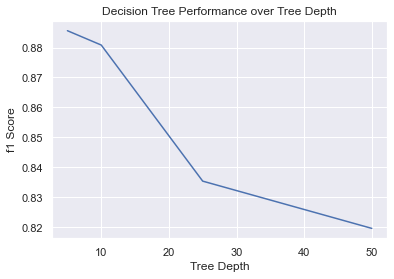

In [129]:
depths = [5, 10, 25, 50]
f1 = []
for depth in depths:
    print ("\n")
    print ("Results for Tree of Depth " + str(depth))
    dt_model = tree.DecisionTreeClassifier(random_state=42, max_depth=depth, criterion="entropy")
    f1.append(model_eval(X_samples, y_samples, dt_model))
    
plt.plot(depths, f1)
plt.title("Decision Tree Performance over Tree Depth")
plt.xlabel("Tree Depth")
plt.ylabel("f1 Score")
plt.show()

## Random Forest Classifier

In [130]:
rf_model = ensemble.RandomForestClassifier(random_state=42, criterion='entropy')
model_eval(X_samples, y_samples[0], rf_model)

recall    = 0.8069 ±0.0020
precision = 0.9909 ±0.0021
f1        = 0.8895 ±0.0014
The time to fit this model was 2.9017 seconds


0.8894915416567333



Results for 5 Estimators
recall    = 0.8147 ±0.0008
precision = 0.9258 ±0.0027
f1        = 0.8667 ±0.0015
The time to fit this model was 0.1775 seconds


Results for 10 Estimators
recall    = 0.8188 ±0.0008
precision = 0.9396 ±0.0026
f1        = 0.8751 ±0.0015
The time to fit this model was 0.3197 seconds


Results for 25 Estimators
recall    = 0.8080 ±0.0019
precision = 0.9827 ±0.0017
f1        = 0.8868 ±0.0012
The time to fit this model was 0.7422 seconds


Results for 50 Estimators
recall    = 0.8081 ±0.0022
precision = 0.9875 ±0.0025
f1        = 0.8888 ±0.0021
The time to fit this model was 1.4586 seconds


Results for 100 Estimators
recall    = 0.8069 ±0.0025
precision = 0.9914 ±0.0012
f1        = 0.8897 ±0.0018
The time to fit this model was 2.9568 seconds


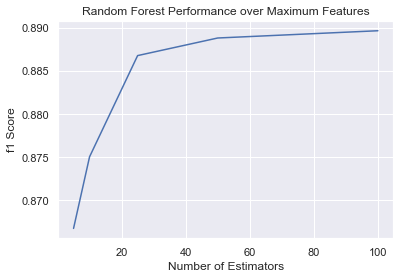

In [133]:
estimators = [5, 10, 25, 50, 100]
f1 = []
for estimator in estimators:
    print ("\n")
    print ("Results for " + str(estimator) + " Estimators")
    rf_model = ensemble.RandomForestClassifier(random_state=42, n_estimators=estimator, criterion="entropy")
    f1.append(model_eval(X_samples, y_samples[0], rf_model))
    
plt.plot(estimators, f1)
plt.title("Random Forest Performance over Maximum Features")
plt.xlabel("Number of Estimators")
plt.ylabel("f1 Score")
plt.show()

## KNN Classifier



Results for 1 Nearest Neighbors
recall    = 0.7944 ±0.0023
precision = 0.8057 ±0.0086
f1        = 0.8000 ±0.0053
The time to fit this model was 0.0197 seconds


Results for 3 Nearest Neighbors
recall    = 0.7953 ±0.0013
precision = 0.9020 ±0.0054
f1        = 0.8453 ±0.0030
The time to fit this model was 0.0150 seconds


Results for 9 Nearest Neighbors
recall    = 0.7918 ±0.0011
precision = 0.9794 ±0.0016
f1        = 0.8757 ±0.0013
The time to fit this model was 0.0144 seconds


Results for 27 Nearest Neighbors
recall    = 0.7903 ±0.0001
precision = 0.9995 ±0.0003
f1        = 0.8827 ±0.0001
The time to fit this model was 0.0156 seconds


Results for 81 Nearest Neighbors
recall    = 0.7901 ±0.0000
precision = 1.0000 ±0.0000
f1        = 0.8828 ±0.0000
The time to fit this model was 0.0165 seconds


Results for 243 Nearest Neighbors
recall    = 0.7901 ±0.0000
precision = 1.0000 ±0.0000
f1        = 0.8828 ±0.0000
The time to fit this model was 0.0176 seconds


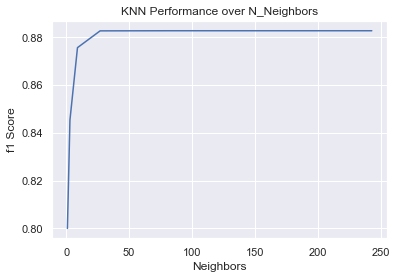

In [134]:
neighbors1 = [1, 3, 9, 27, 81, 243]
f1 = []
for neighbor in neighbors1:
    print ("\n")
    print ("Results for " + str(neighbor) +" Nearest Neighbors")
    knn_model = neighbors.KNeighborsClassifier(n_neighbors=neighbor)
    f1.append(model_eval(X_samples, y_samples[0], knn_model))
    
plt.plot(neighbors1, f1)
plt.title("KNN Performance over N_Neighbors")
plt.xlabel("Neighbors")
plt.ylabel("f1 Score")
plt.show()

## MLP Classifier

In [135]:
mlp_model = neural_network.MLPClassifier(hidden_layer_sizes=(20,20,20), max_iter=1000, activation="tanh", random_state=42)
scaled_model_eval(X_samples, y_samples[0], mlp_model);

recall    = 0.8242 ±0.0060
precision = 0.8320 ±0.0095
f1        = 0.8281 ±0.0073
The time to fit this model was 72.2274 seconds


In [136]:
mlp_model = neural_network.MLPClassifier(hidden_layer_sizes=(20,20,20), max_iter=1000, activation="logistic",  random_state=42)
scaled_model_eval(X_samples, y_samples[0], mlp_model)

recall    = 0.8276 ±0.0037
precision = 0.8792 ±0.0086
f1        = 0.8526 ±0.0046
The time to fit this model was 70.7697 seconds


0.8526065112819786



Results for (20, 20, 20) Architecture
recall    = 0.8268 ±0.0029
precision = 0.8831 ±0.0112
f1        = 0.8539 ±0.0046
The time to fit this model was 72.1847 seconds


Results for (20, 20, 20, 20, 20) Architecture
recall    = 0.8245 ±0.0029
precision = 0.9092 ±0.0151
f1        = 0.8647 ±0.0061
The time to fit this model was 78.5938 seconds


Results for (20, 20, 20, 20, 20, 20, 20, 20, 20, 20) Architecture
recall    = 0.7901 ±0.0000
precision = 1.0000 ±0.0000
f1        = 0.8828 ±0.0000
The time to fit this model was 2.6503 seconds


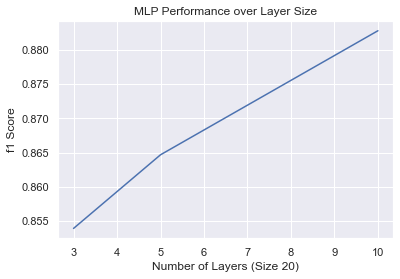

In [137]:
architectures = [(20,20,20), (20,20,20,20,20), (20,20,20,20,20,20,20,20,20,20)]
arch_layers=[3, 5, 10]
f1 = []
for architecture in architectures:
    print ("\n")
    print ("Results for " + str(architecture) +" Architecture")
    mlp_model = neural_network.MLPClassifier(hidden_layer_sizes=architecture, max_iter=1000, activation="logistic", random_state=42)
    f1.append(scaled_model_eval(X_samples, y_samples[0], mlp_model))
    
plt.plot(arch_layers, f1)
plt.title("MLP Performance over Layer Size")
plt.xlabel("Number of Layers (Size 20)")
plt.ylabel("f1 Score")
plt.show()

## Results

In [139]:
dt_model = tree.DecisionTreeClassifier(random_state=42, max_depth=1, criterion="entropy")
model_eval(X, y, dt_model)

recall    = 0.7990 ±0.0002
precision = 0.9961 ±0.0001
f1        = 0.8867 ±0.0001
The time to fit this model was 6.0372 seconds


0.8867039481094627

In [138]:
# Since computation at this depth is relatively cheap, I fit a second decision tree and on the entire dataset, a depth of 5 outperformed the depth of 1.
dt_model = tree.DecisionTreeClassifier(random_state=42, max_depth=5, criterion="entropy")
model_eval(X, y, dt_model)

recall    = 0.8002 ±0.0004
precision = 0.9945 ±0.0007
f1        = 0.8868 ±0.0001
The time to fit this model was 21.6936 seconds


0.8868216692955118

In [140]:
rf_model = ensemble.RandomForestClassifier(random_state=42, n_estimators=50, criterion='entropy')
model_eval(X, y[0], rf_model)

recall    = 0.8257 ±0.0001
precision = 0.9761 ±0.0002
f1        = 0.8946 ±0.0001
The time to fit this model was 550.8517 seconds


0.8946140324326797

In [142]:
# This model runs overnight

mlp_model = neural_network.MLPClassifier(hidden_layer_sizes=(20,20,20,20,20,20,20,20,20,20), max_iter=1000, activation="logistic",  random_state=42)
scaled_model_eval(X, y[0], mlp_model)

recall    = 0.7892 ±0.0000
precision = 1.0000 ±0.0000
f1        = 0.8822 ±0.0000
The time to fit this model was 2649.5669 seconds


0.8822081051897331

In [36]:
# This model would not run after 72 hours.

knn_model = neighbors.KNeighborsClassifier(n_neighbors=27, algorithm='ball_tree', n_jobs=-1)
model_eval(X, y[0], knn_model)